INSTALL ROCKFISH SDK

In [0]:
# GENERATE SYNTHETIC DATASET USING ROCKFISH

%pip install -U 'rockfish[labs]' -f 'https://docs142.rockfish.ai/packages/index.html' 
%restart_python


Looking in links: https://docs142.rockfish.ai/packages/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/12.8 MB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/12.8 MB 3.3 MB/s eta 0:00:04
     ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/12.8 MB 16.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 5.9/12.8 MB 56.6 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 12.1/12.8 MB 168.9 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 12.8/12.8 MB 167.9 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.9 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


SETUP ROCKFISH ENVIRONMENT VARIABLES

In [0]:
# Rockfish Environment Key
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs as rl
#api_key = "<ENTER YOUR API_KEY HERE>"
#api_url = "<ENTER YOUR API_URL HERE>"
conn = rf.Connection.remote(api_url, api_key)

env: ROCKFISH_API_KEY=api_key


GENERATE SYNTHETIC DATA

In [0]:
import pandas as pd

# Read a CSV file
#df = pd.read_csv('<PATH_TO_SAMPLE_DATA_CSV>')

#Onboard
# Perform any necessary feature engineering or preprocessing
dataset = rf.Dataset.from_pandas("<NAME_OF_DATASET>",df)

categorical_fields = (
    df.select_dtypes(include=["object"]).columns
)
print(categorical_fields)

config = {
    "encoder": {
        "metadata": [
            {"field": field, "type": "categorical"}
            for field in categorical_fields
        ]
        + [
            {"field": field, "type": "continuous"}
            for field in dataset.table.column_names
            if field not in categorical_fields
        ],
    },
    "tabular-gan": {
        "epochs": 20,
        "records": 100000,
    }
}
print(dataset.table.column_names)

#Train
train = ra.TrainTabGAN(config)

builder = rf.WorkflowBuilder()
builder.add_dataset(dataset)
builder.add_action(train, parents=[dataset])
workflow = await builder.start(conn)

print(f"Workflow: {workflow.id()}")

async for log in workflow.logs():
    print(log) 


model = await workflow.models().nth(0)
await model.add_labels(conn)
model

#Generate
generate = ra.GenerateTabGAN(config)
save = ra.DatasetSave({"name": "synthetic"})
builder = rf.WorkflowBuilder()
builder.add_model(model)
builder.add_action(generate, parents=[model])
builder.add_action(save, parents=[generate])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

syn = None
async for sds in workflow.datasets():
    syn = await sds.to_local(conn)


Index(['customer', 'age', 'gender', 'merchant', 'category'], dtype='object')
['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount', 'timestamp', 'fraud']
Workflow: 4ySAkjf4OD417riPONNgeW
2024-11-27T18:26:04Z dataset-load: INFO Loading dataset '2gQzGyS84ekvy36hmsPF01' with 118929 rows
2024-11-27T18:25:58Z train-tab-gan: INFO Starting training...
2024-11-27T18:27:01Z train-tab-gan: INFO Epoch 1 completed
2024-11-27T18:27:23Z train-tab-gan: INFO Epoch 2 completed
2024-11-27T18:27:44Z train-tab-gan: INFO Epoch 3 completed
2024-11-27T18:28:06Z train-tab-gan: INFO Epoch 4 completed
2024-11-27T18:28:28Z train-tab-gan: INFO Epoch 5 completed
2024-11-27T18:28:49Z train-tab-gan: INFO Epoch 6 completed
2024-11-27T18:29:11Z train-tab-gan: INFO Epoch 7 completed
2024-11-27T18:29:32Z train-tab-gan: INFO Epoch 8 completed
2024-11-27T18:29:54Z train-tab-gan: INFO Epoch 9 completed
2024-11-27T18:30:16Z train-tab-gan: INFO Epoch 10 completed
2024-11-27T18:30:37Z train-tab-gan: INFO Epoc

/databricks/python/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/databricks/python/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/databricks/python/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/databricks/python/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When

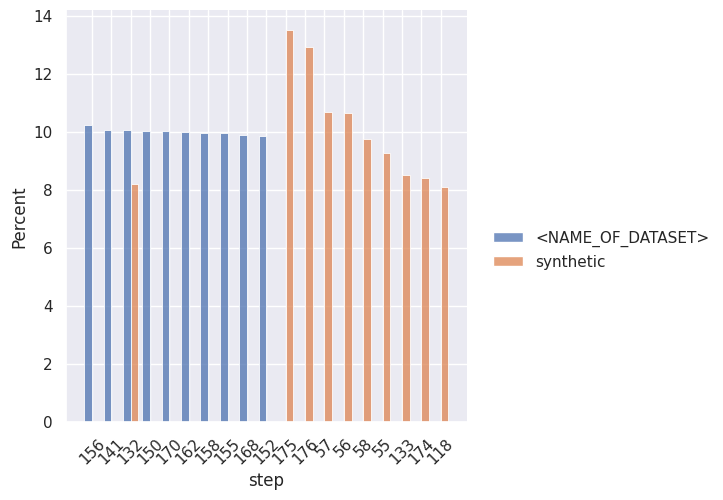

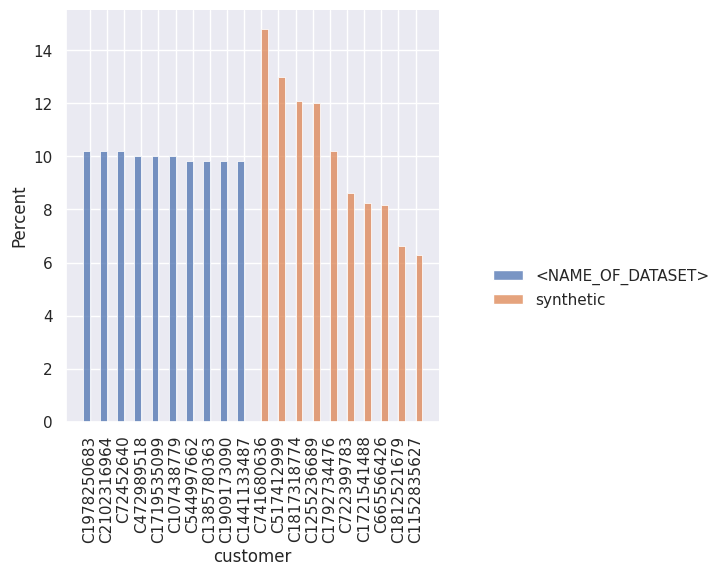

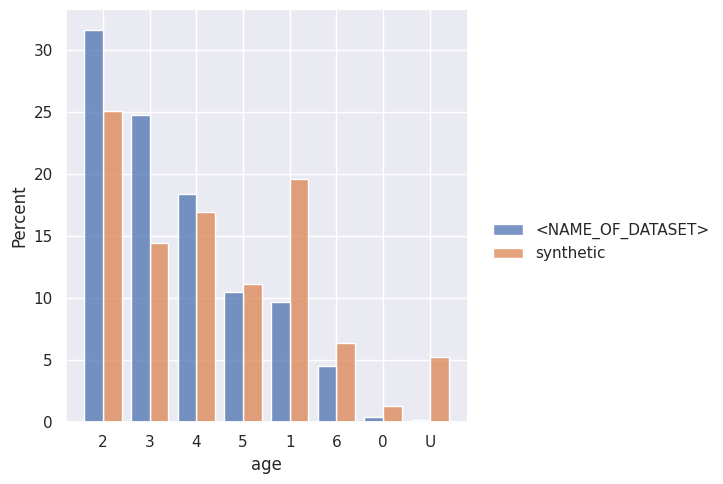

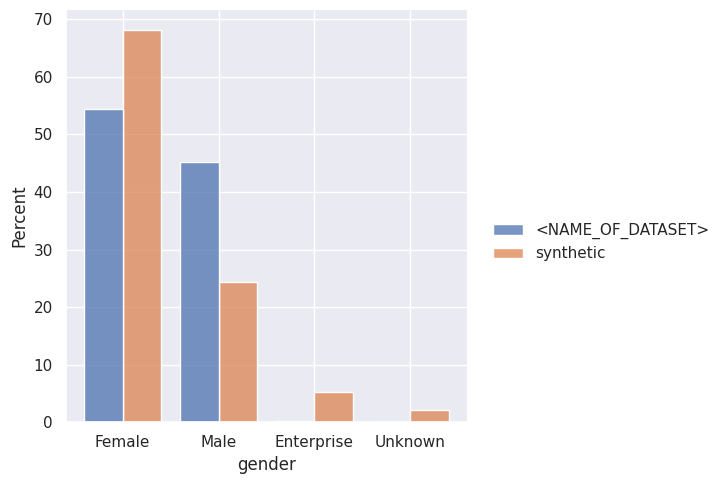

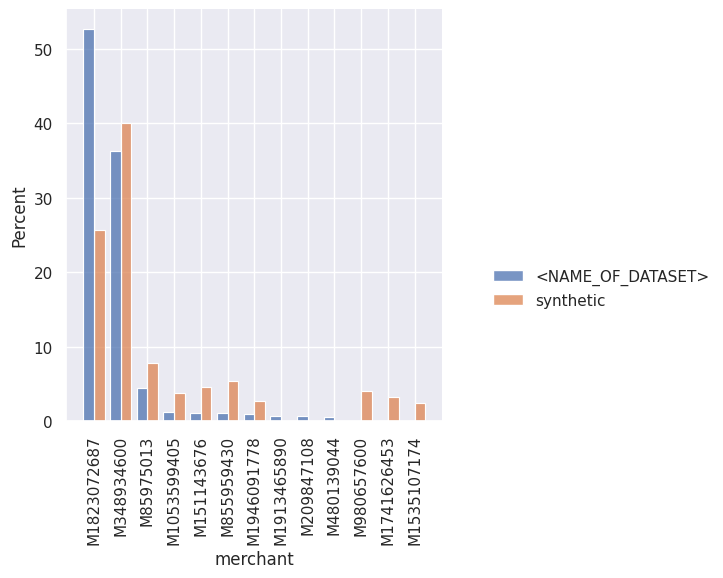

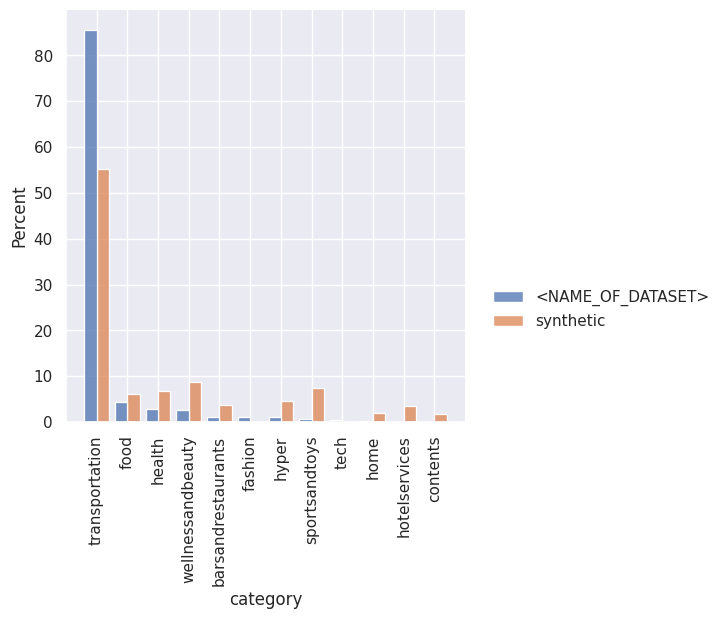

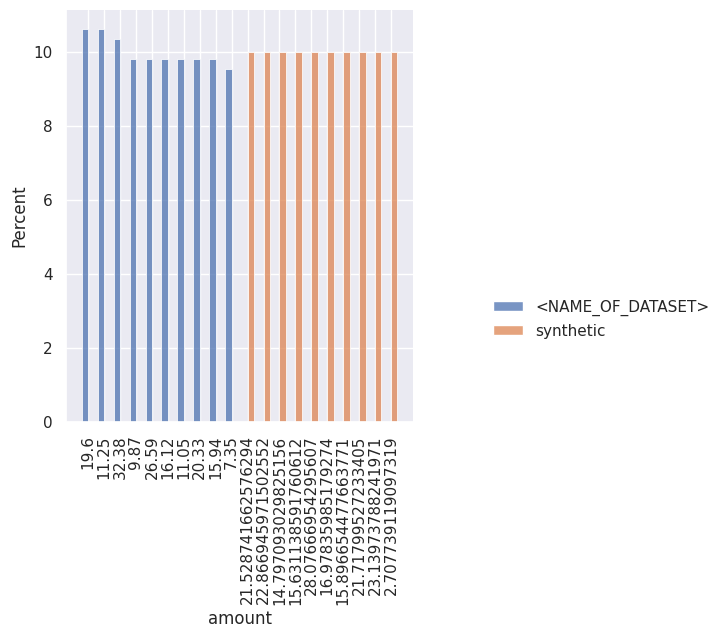

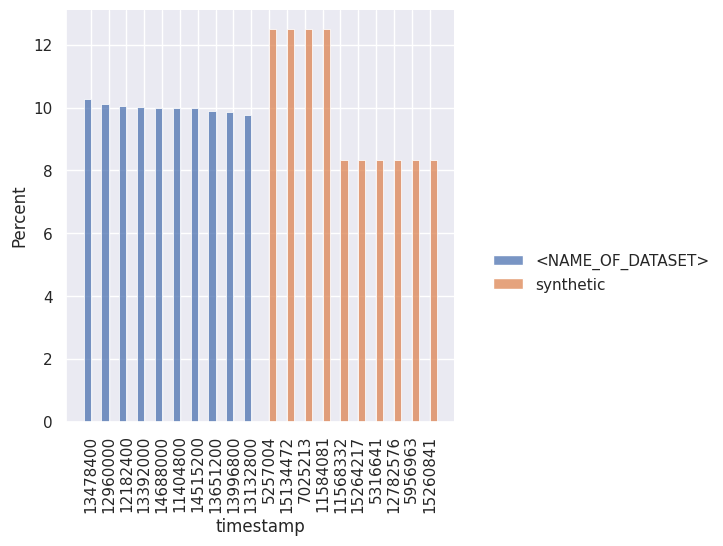

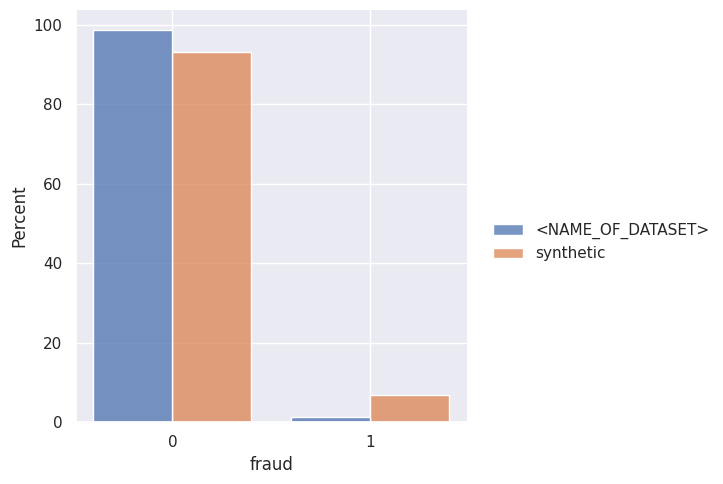

In [0]:
for col in dataset.table.column_names:
    source_agg = rf.metrics.count_all(dataset, col, nlargest=10)
    syn_agg = rf.metrics.count_all(syn, col, nlargest=10)
    rl.vis.plot_bar([source_agg, syn_agg], col, f"{col}_count")